In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import math
import seaborn as sns


In [142]:
# Jupyter configuration
pd.set_option('display.max_rows', 500)
%matplotlib inline

In [143]:
all_countries_dataset = pd.read_csv('all_countries_dataset.csv')

In [144]:
# drop cloumn Unnamed: 0

if 'Unnamed: 0' in all_countries_dataset.columns:
    all_countries_dataset = all_countries_dataset.drop(columns=['Unnamed: 0'])

# Fixing date column datatype
all_countries_dataset['date'] = pd.to_datetime(all_countries_dataset['date'])
all_countries_dataset['location'] = all_countries_dataset['location'].astype('category');

# all_countries_dataset.set_index('date', inplace=True)


In [150]:
start_date = all_countries_dataset["date"].min()
end_date =  all_countries_dataset["date"].max()

delta_time = end_date - start_date
delta_time

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


Timedelta('670 days 00:00:00')

In [147]:
def plot_data_in_time(dataset):
    for column in dataset.columns:
        if dataset[column].dtype != 'float64':
            continue
        dataset.plot(kind='line', x='date', y=column, figsize=(10, 2));
    plt.show()

### Countrie with total cases < 2% of population

In [152]:
all_continents = all_countries_dataset['continent'].unique()

countries_to_exclude = []
treashold_population_infected_percentage = 2

for continent in all_continents:
    max_percentage = 0
    min_percentage = 100
    
    print("==== Continent: {} ====".format(continent))
    
    for index, row in all_countries_dataset.iterrows():
        if row['continent'] == continent and row['date'] == end_date and not pd.isna(row['population']) and not pd.isna(row['total_cases']):
            percentage_population_infected = row['total_cases'] / row['population'] * 100

            max_percentage = max(percentage_population_infected, max_percentage)
            min_percentage = min(percentage_population_infected, min_percentage)

            print("{} - {} - {} - {}".format(row['location'], row['total_cases'], row['population'], percentage_population_infected))

            if percentage_population_infected < treashold_population_infected_percentage:
                countries_to_exclude.append(row['location'])

    print("Max: {}".format(max_percentage))
    print("Min: {}".format(min_percentage))
    
    print("\n")


==== Continent: Asia ====
Afghanistan - 156284.0 - 39835428.0 - 0.39232413920593495
Armenia - 309397.0 - 2968128.0 - 10.423977672121957
Azerbaijan - 532570.0 - 10223344.0 - 5.2093522432581745
Bahrain - 276874.0 - 1748295.0 - 15.836800997543321
Bangladesh - 1569753.0 - 166303494.0 - 0.9439086108437386
Bhutan - 2621.0 - 779900.0 - 0.336068726759841
Brunei - 13246.0 - 441532.0 - 3.000009059366026
Cambodia - 118613.0 - 16946446.0 - 0.6999284687774652
China - 97391.0 - 1444216102.0 - 0.006743519883563797
Georgia - 721388.0 - 3979773.0 - 18.126360473323476
Hong Kong - 12347.0 - 7552800.0 - 0.16347579705539667
India - 34296237.0 - 1393409033.0 - 2.4613186930588817
Indonesia - 4244761.0 - 276361788.0 - 1.5359435292117882
Iran - 5934495.0 - 85028760.0 - 6.979397323917224
Iraq - 2056401.0 - 41179351.0 - 4.993767385989158
Israel - 1328218.0 - 8789776.0 - 15.110942531413771
Japan - 1723645.0 - 126050796.0 - 1.3674209562310102
Jordan - 864661.0 - 10269022.0 - 8.420091027168898
Kazakhstan - 1021452.

In [153]:
print("The countries to exclude are: {}".format(countries_to_exclude))
print("\n")
print("The number of countries to exclude: {}".format(len(countries_to_exclude)))

The countries to exclude are: ['Afghanistan', 'Bangladesh', 'Bhutan', 'Cambodia', 'China', 'Hong Kong', 'Indonesia', 'Japan', 'Laos', 'Myanmar', 'Pakistan', 'Saudi Arabia', 'South Korea', 'Syria', 'Taiwan', 'Tajikistan', 'Timor', 'Uzbekistan', 'Vietnam', 'Yemen', 'Algeria', 'Angola', 'Benin', 'Burkina Faso', 'Burundi', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo', "Cote d'Ivoire", 'Democratic Republic of Congo', 'Djibouti', 'Egypt', 'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Mozambique', 'Niger', 'Nigeria', 'Rwanda', 'Sao Tome and Principe', 'Senegal', 'Sierra Leone', 'Somalia', 'South Sudan', 'Sudan', 'Tanzania', 'Togo', 'Uganda', 'Zambia', 'Zimbabwe', 'El Salvador', 'Haiti', 'Nicaragua', 'Venezuela', 'Australia', 'Kiribati', 'Marshall Islands', 'Micronesia (country)', 'New Zealand', 'Palau', 'Papua New Guinea', 'Samoa

In [154]:
print("All available countrie: {}".format(len(all_countries_dataset['location'].unique())))

valid_countries_data = all_countries_dataset[~all_countries_dataset['location'].isin(countries_to_exclude)]

print("Romanining valid countries: {}".format(len(valid_countries_data['location'].unique())))


All available countrie: 224
Romanining valid countries: 144


### Calculate var coverage for each country and select variable that have a mean coverage less than a threshold

In [180]:
var_cov_threshold = 50
var_to_exclude = []

def var_coverage():
    countries = valid_countries_data['location'].unique()
    variables = valid_countries_data.columns

    for variable in variables:
        if valid_countries_data[variable].dtype != 'float64':
            continue
        var_cov_percentage_sum = 0
        print("======= {} =======".format(variable))
        for country in countries:
            country_data = valid_countries_data[valid_countries_data['location'] == country]
            all_rows = country_data.shape[0]
            nans = country_data[variable].isna().sum()
            nans_percentage = (nans / all_rows) * 100
            var_coverage_percentage = 100 - nans_percentage
            var_cov_percentage_sum = var_cov_percentage_sum + var_coverage_percentage
            print("{} = {:.2f}%".format(country, var_coverage_percentage))
        var_cov_mean = var_cov_percentage_sum / len(countries)
        if var_cov_mean < var_cov_threshold:
            var_to_exclude.append(variable)
        print("===== Var cov mean for {} = {:.2f}%".format(variable, var_cov_mean))
        print("\n")

var_coverage()

======= total_cases =======
Albania = 97.89%
Andorra = 100.00%
Anguilla = 0.00%
Antigua and Barbuda = 100.00%
Argentina = 90.76%
Armenia = 100.00%
Aruba = 0.00%
Austria = 100.00%
Azerbaijan = 100.00%
Bahamas = 100.00%
Bahrain = 100.00%
Barbados = 100.00%
Belarus = 100.00%
Belgium = 100.00%
Belize = 100.00%
Bermuda = 0.00%
Bolivia = 100.00%
Bonaire Sint Eustatius and Saba = 0.00%
Bosnia and Herzegovina = 100.00%
Botswana = 100.00%
Brazil = 100.00%
British Virgin Islands = 0.00%
Brunei = 100.00%
Bulgaria = 100.00%
Canada = 100.00%
Cape Verde = 100.00%
Cayman Islands = 0.00%
Chile = 100.00%
Colombia = 100.00%
Cook Islands = 0.00%
Costa Rica = 100.00%
Croatia = 100.00%
Cuba = 100.00%
Curacao = 0.00%
Cyprus = 99.67%
Czechia = 98.87%
Denmark = 96.09%
Dominica = 100.00%
Dominican Republic = 100.00%
Ecuador = 100.00%
Estonia = 96.24%
Eswatini = 100.00%
Faeroe Islands = 0.00%
Falkland Islands = 0.00%
Fiji = 92.37%
Finland = 100.00%
France = 100.00%
French Polynesia = 0.00%
Georgia = 100.00%
Ger

In [181]:
print("The variables to exclude are: {}".format(var_to_exclude))
print("Number of variables to exlude {}".format(len(var_to_exclude)))

The variables to exclude are: ['icu_patients', 'icu_patients_per_million', 'hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters', 'new_vaccinations', 'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred', 'extreme_poverty', 'handwashing_facilities', 'excess_mortality_cumulative_absolute', 'excess_mortality_cumulative', 'excess_mortality', 'excess_mortality_cumulative_per_million']
Number of variables to exlude 27


### Calculate correlations between the remaining variables

<AxesSubplot:>

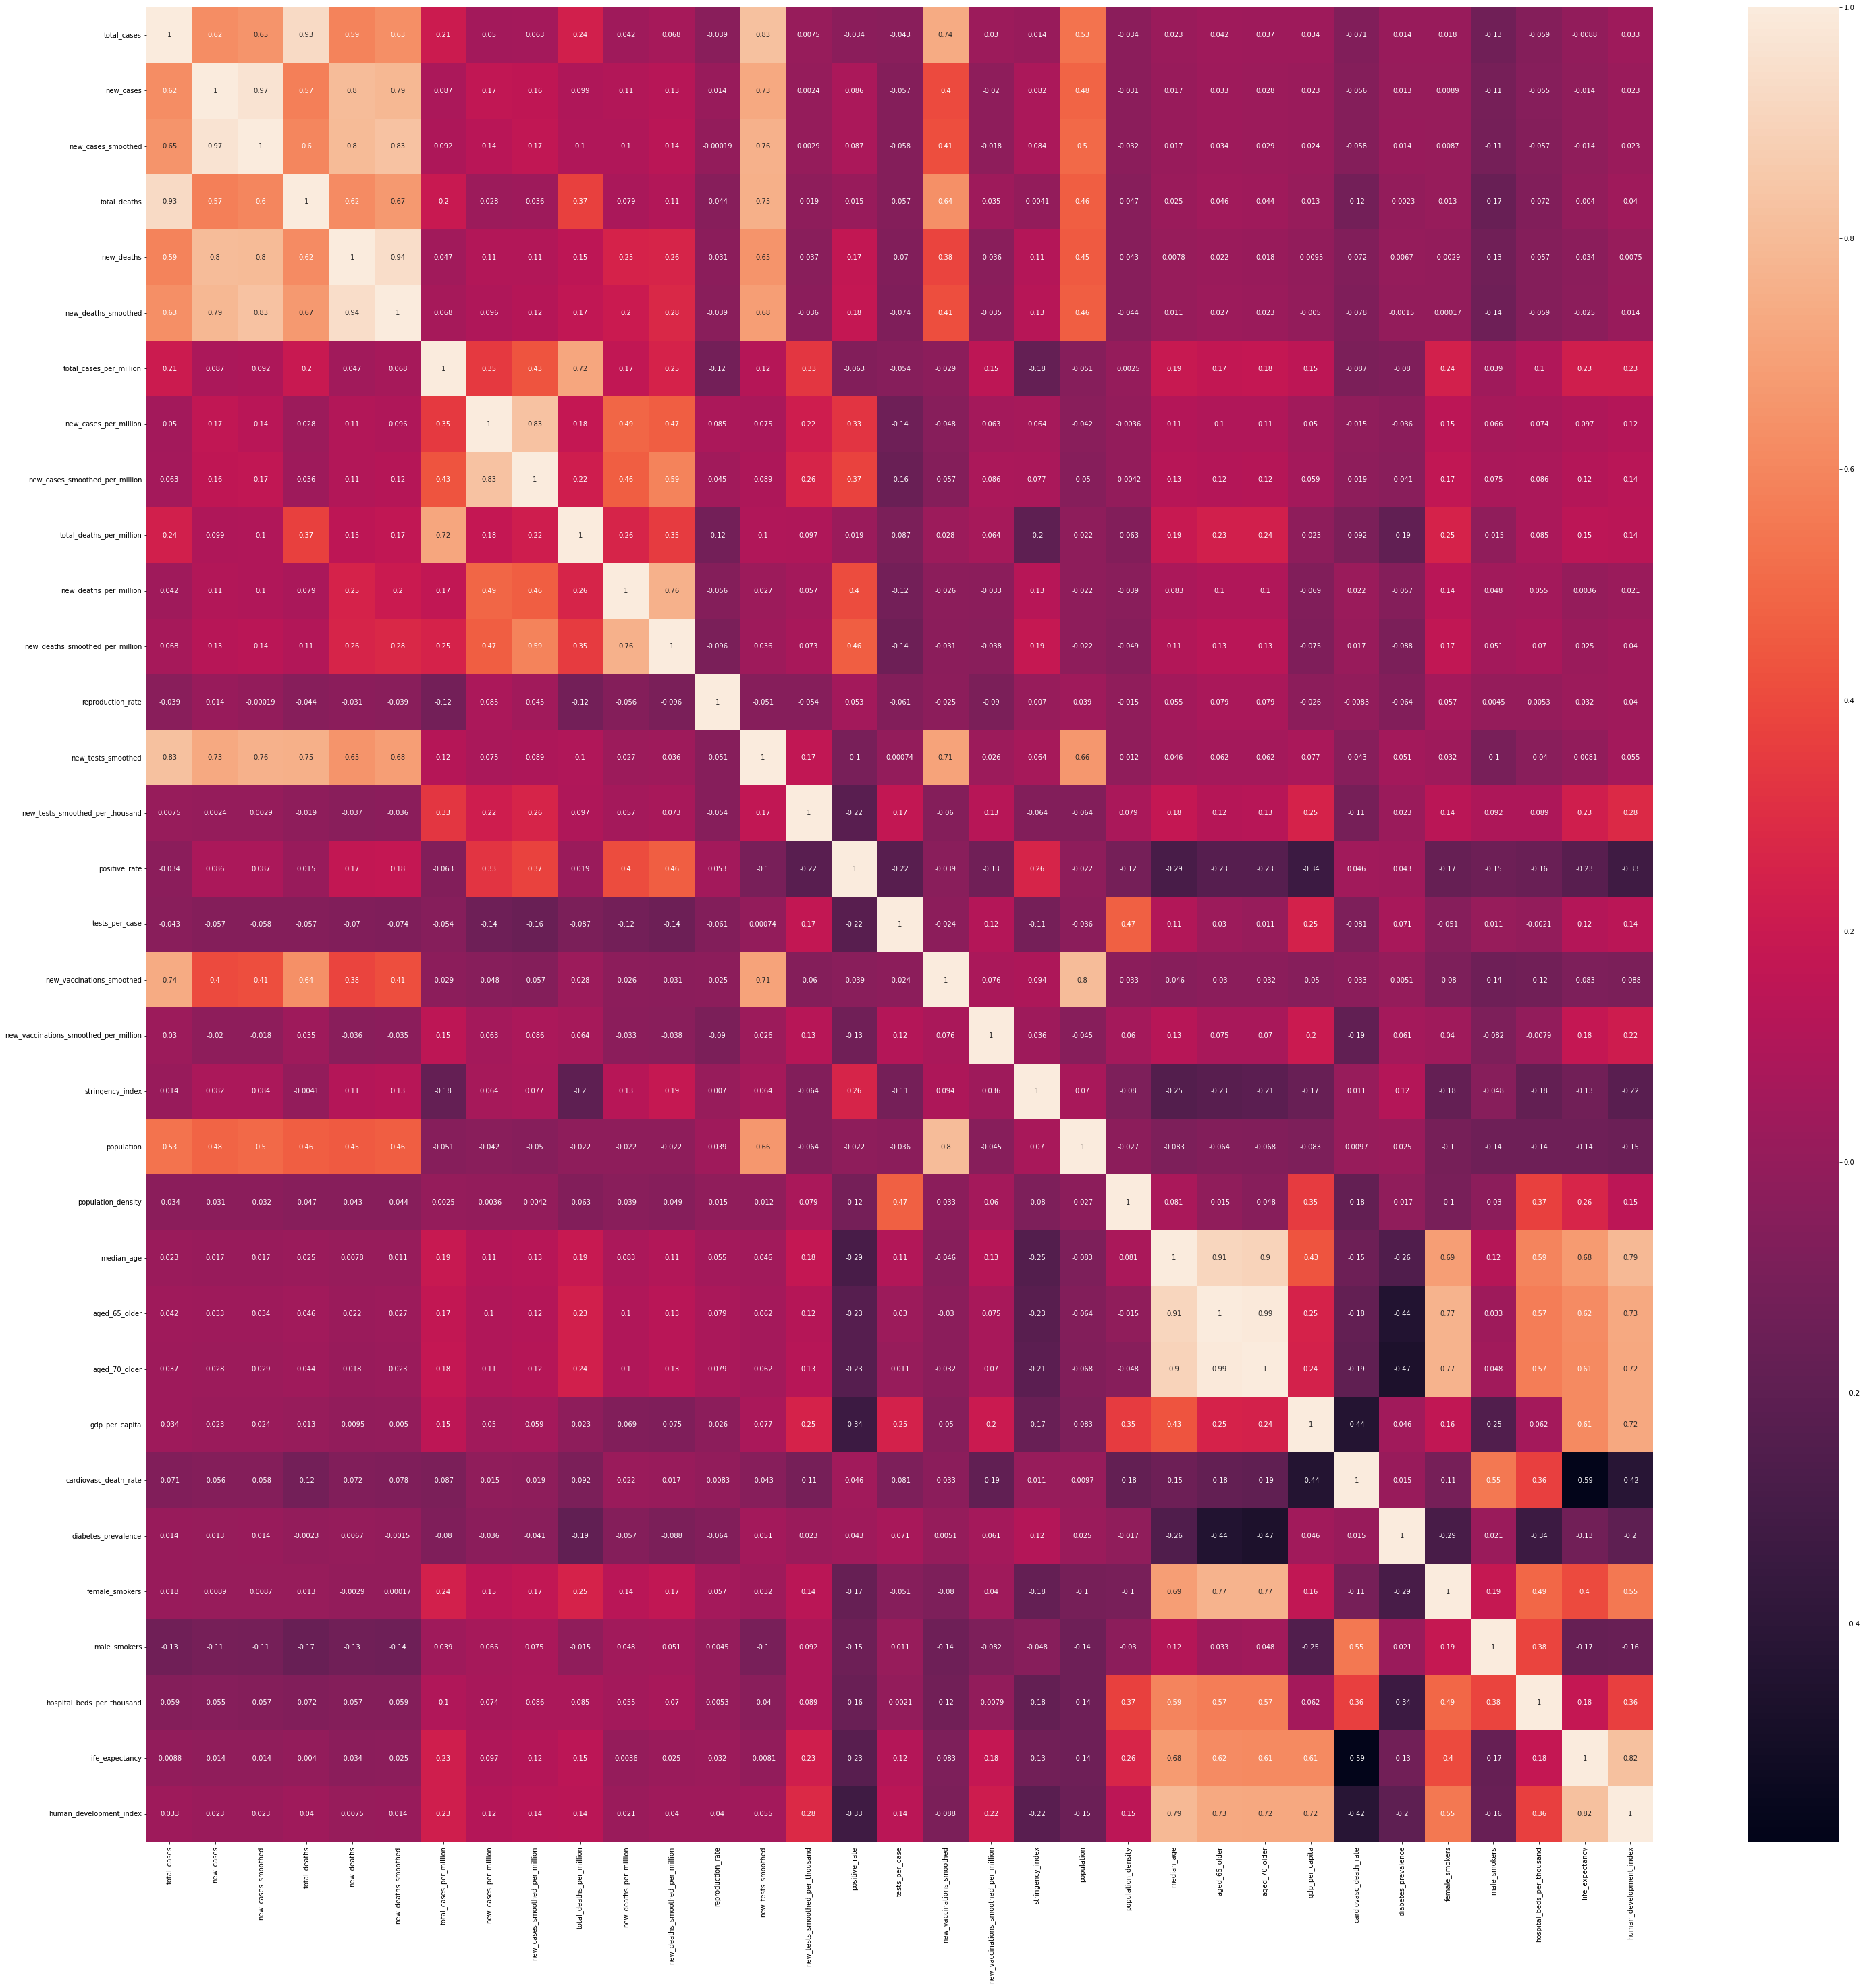

In [182]:
remaining_variables = valid_countries_data.columns.drop(var_to_exclude)
valid_countries_data = valid_countries_data[remaining_variables]

corr = valid_countries_data.corr()
plt.figure(figsize=(50,50))
sns.heatmap(corr, annot=True)

In [186]:
THRESHOLD_CORRELATION = 0.5
TARGET_VARIABLE = 'new_deaths'

variables_to_drop = []

for variable in valid_countries_data.columns:
    if valid_countries_data[variable].dtype != 'float64':
        continue
    correltation = abs(valid_countries_data[variable].corr(valid_countries_data[TARGET_VARIABLE]))
    if correltation < THRESHOLD_CORRELATION and variable != TARGET_VARIABLE:
        print("{} = {}".format(variable, correltation))
        variables_to_drop.append(variable)

total_cases_per_million = 0.0473952743839364
new_cases_per_million = 0.10650945403999992
new_cases_smoothed_per_million = 0.11077892466512579
total_deaths_per_million = 0.1537338923307614
new_deaths_per_million = 0.24906081678062175
new_deaths_smoothed_per_million = 0.25548965945824553
reproduction_rate = 0.030695999087187568
new_tests_smoothed_per_thousand = 0.036714035579238115
positive_rate = 0.17149221137195178
tests_per_case = 0.06999297564963528
new_vaccinations_smoothed = 0.3815816275051096
new_vaccinations_smoothed_per_million = 0.03649974241344688
stringency_index = 0.114982469317423
population = 0.4479623315545099
population_density = 0.043092452517635604
median_age = 0.0078010414891894414
aged_65_older = 0.021787912336012925
aged_70_older = 0.018338674789965956
gdp_per_capita = 0.00953785180225324
cardiovasc_death_rate = 0.07210315455207257
diabetes_prevalence = 0.006667962658747695
female_smokers = 0.002931654235180115
male_smokers = 0.12978233359287183
hospital_beds_per_th

In [188]:
print("\n")
print("Variables to drop {}".format(variables_to_drop))
print(len(variables_to_drop))
print("\n")



Variables to drop ['total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'reproduction_rate', 'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case', 'new_vaccinations_smoothed', 'new_vaccinations_smoothed_per_million', 'stringency_index', 'population', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers', 'male_smokers', 'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index']
26




In [189]:
for variable in valid_countries_data.columns:
    if valid_countries_data[variable].dtype != 'float64':
        continue
    if variable not in variables_to_drop:
        correltation = abs(valid_countries_data[variable].corr(valid_countries_data[TARGET_VARIABLE]))
        print("{} = {}".format(variable, correltation))

total_cases = 0.585848792805706
new_cases = 0.801910230311689
new_cases_smoothed = 0.7990680644324424
total_deaths = 0.6213210059115002
new_deaths = 1.0
new_deaths_smoothed = 0.9428418861426563
new_tests_smoothed = 0.6464450792657077
